In [0]:
!apt install proj-bin libproj-dev libgeos-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  libgdal-doc
The following NEW packages will be installed:
  libgeos-dev libproj-dev proj-bin
0 upgraded, 3 newly installed, 0 to remove and 8 not upgraded.
Need to get 305 kB of archives.
After this operation, 1,706 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgeos-dev amd64 3.6.2-1build2 [73.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libproj-dev amd64 4.9.3-2 [199 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 proj-bin amd64 4.9.3-2 [32.3 kB]
Fetched 305 kB in 1s (276 kB/s)
Selecting previously unselected package libgeos-dev.
(Reading database ... 110842 files and directories currently installed.)
Preparing to unpack .../libgeos-dev_3.6.2-1build2_amd64.deb ...
Unpacking libgeos-dev (3.6.2-1build2) ...
Selecting previously unselected package libproj-dev:amd64.
Preparin

In [0]:
!pip install https://github.com/matplotlib/basemap/archive/v1.1.0.tar.gz

     | 165.5MB 20.2MB/s
    100% |████████████████████████████████| 4.4MB 3.6MB/s 
    100% |████████████████████████████████| 215kB 19.9MB/s 
  Running setup.py bdist_wheel for basemap ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done
  Stored in directory: /tmp/pip-ephem-wheel-cache-b0ge95zt/wheels/6c/c2/bd/d6fb8f2660e0591d357352aba1b117b3211d016994d933d792
  Running setup.py bdist_wheel for pyproj ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / done
  Stored in directory: /root/.cache/pip/wheels/89/77/ec/a537585d1022dafde0317dd19d33c4a3

In [0]:
import datetime as dt
from sklearn.model_selection import RandomizedSearchCV
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from mpl_toolkits.basemap import Basemap
from sklearn.model_selection import TimeSeriesSplit
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import log_loss
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

SEED = 5
np.random.seed(seed=SEED)

import warnings
warnings.filterwarnings("ignore")

## Data Processing

In [0]:
accidents = pd.read_csv('Acc.csv',index_col='Accident_Index')
casualties=pd.read_csv('Cas.csv' , error_bad_lines=False,index_col='Accident_Index',warn_bad_lines=False)
vehicles=pd.read_csv('Veh.csv', error_bad_lines=False,index_col='Accident_Index',warn_bad_lines=False)

In [0]:
accidents = accidents.join(vehicles, how='outer')
accidents.shape
#identifying missing values
#According to the Data Guide, there are two types of missing values '-1'and 'Nan'
#accidents.dropna(axis=1, how='all', inplace= True)
accidents.replace('-1', np.nan, inplace=True)
accidents.replace('-1.0', np.nan, inplace=True)
accidents.replace(-1.0, np.nan, inplace=True)
accidents.dropna(axis= 0, how= 'any', inplace=True)

accidents.shape

(45079, 53)

In [0]:
pd.set_option('display.max_columns', None)

# define function to convert to hour 
def tohour(time):
    try:
        hour = datetime.strptime(str(time), '%H:%M')
        return int(datetime.strftime(hour, '%H'))
    except Exception:
        return 0
    
    
# format Date in Datetime format and add additional columns for month, day, and hour
accidents['Date'] = pd.to_datetime(accidents['Date'], format='%d/%m/%Y')
accidents['Month'] = accidents['Date'].dt.month
accidents['Day'] = accidents['Date'].dt.day
accidents['Hour of Day'] = accidents['Time'].apply(tohour)

# display cleaned file
accidents.head()

,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,1st_Road_Number,Road_Type,Speed_limit,Junction_Detail,Junction_Control,2nd_Road_Class,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location,Vehicle_Reference,Vehicle_Type,Towing_and_Articulation,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,Hit_Object_off_Carriageway,1st_Point_of_Impact,Was_Vehicle_Left_Hand_Drive?,Journey_Purpose_of_Driver,Sex_of_Driver,Age_of_Driver,Age_Band_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Driver_IMD_Decile,Driver_Home_Area_Type,Vehicle_IMD_Decile,Month,Day,Hour of Day
Accident_Index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017010009342,526790.0,181970.0,-0.173845,51.522425,1.0,3.0,2.0,1.0,2017-01-01,1.0,01:30,1.0,E09000033,3.0,5.0,6.0,30.0,3.0,4.0,6.0,0.0,0.0,0.0,4.0,1.0,2.0,0.0,0.0,1.0,1.0,E01004702,1.0,9.0,0.0,18.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,6.0,1.0,33.0,6.0,1797.0,8.0,8.0,9.0,1.0,9.0,1,1,1
2017010009342,526790.0,181970.0,-0.173845,51.522425,1.0,3.0,2.0,1.0,2017-01-01,1.0,01:30,1.0,E09000033,3.0,5.0,6.0,30.0,3.0,4.0,6.0,0.0,0.0,0.0,4.0,1.0,2.0,0.0,0.0,1.0,1.0,E01004702,2.0,9.0,0.0,18.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,6.0,1.0,40.0,7.0,2204.0,2.0,12.0,2.0,1.0,2.0,1,1,1
2017010009344,535200.0,181260.0,-0.052969,51.514096,1.0,3.0,3.0,1.0,2017-01-01,1.0,00:30,5.0,E09000030,3.0,13.0,6.0,30.0,3.0,4.0,5.0,0.0,0.0,0.0,4.0,1.0,1.0,0.0,0.0,1.0,1.0,E01004298,3.0,9.0,0.0,18.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,6.0,2.0,31.0,6.0,1299.0,1.0,14.0,5.0,1.0,5.0,1,1,0
2017010009348,534340.0,193560.0,-0.060658,51.624832,1.0,3.0,2.0,1.0,2017-01-01,1.0,01:11,32.0,E09000010,3.0,1010.0,1.0,30.0,1.0,4.0,4.0,154.0,0.0,4.0,4.0,2.0,2.0,0.0,0.0,1.0,1.0,E01001429,1.0,9.0,0.0,18.0,0.0,4.0,0.0,9.0,0.0,0.0,1.0,1.0,6.0,2.0,37.0,7.0,1399.0,1.0,9.0,2.0,1.0,2.0,1,1,1
2017010009348,534340.0,193560.0,-0.060658,51.624832,1.0,3.0,2.0,1.0,2017-01-01,1.0,01:11,32.0,E09000010,3.0,1010.0,1.0,30.0,1.0,4.0,4.0,154.0,0.0,4.0,4.0,2.0,2.0,0.0,0.0,1.0,1.0,E01001429,2.0,9.0,0.0,9.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,1.0,6.0,2.0,29.0,6.0,1797.0,8.0,6.0,4.0,1.0,4.0,1,1,1


## Machine Learning

In [0]:
accident_ml = accidents.drop('Accident_Severity' ,axis=1)
accident_ml = accidents.drop('Local_Authority_(Highway)' ,axis=1)
accident_ml = accidents.drop('LSOA_of_Accident_Location' ,axis=1)
# Split the data into a training and test set.
accident_ml = accident_ml[['Longitude', 'Latitude','Urban_or_Rural_Area','Vehicle_Manoeuvre','Vehicle_Location-Restricted_Lane',
                           'Hit_Object_in_Carriageway', 'Hit_Object_off_Carriageway','Age_of_Driver',
                           'Vehicle_Type','Special_Conditions_at_Site','Road_Surface_Conditions','Police_Force',
                           'Road_Type', 'Junction_Detail','Junction_Control','Pedestrian_Crossing-Physical_Facilities',
                           'Did_Police_Officer_Attend_Scene_of_Accident' ,'Vehicle_Type', 'Age_of_Vehicle',
                           'Engine_Capacity_(CC)','Day_of_Week', 'Weather_Conditions', 
                           'Light_Conditions', 'Sex_of_Driver' ,'Speed_limit']]



X_train, X_test, y_train, y_test = train_test_split(accident_ml.values, 
                                              accidents['Accident_Severity'].values,test_size=0.20, random_state=8)

In [0]:
#given that Accident severity is the one that need to be predicted, and this presents
# heavily imbalance https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets
from imblearn.over_sampling import SMOTE
smote = SMOTE(ratio='minority')
X_sm, y_sm = smote.fit_sample(X_train, y_train)

In [0]:
#random forest

random_forest = RandomForestClassifier(n_estimators=200)
random_forest.fit(X_train,y_train)

Y_pred = random_forest.predict(X_test)
random_forest.score(X_test, y_test)
acc_random_forest1 = round(random_forest.score(X_test, y_test) * 100, 2)

sk_report = classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=Y_pred)

print("Accuracy" , acc_random_forest1)
print(sk_report)
pd.crosstab(y_test, Y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)

Accuracy 84.47
              precision    recall  f1-score   support

         1.0   0.000000  0.000000  0.000000        54
         2.0   0.465347  0.035075  0.065232      1340
         3.0   0.849114  0.993046  0.915457      7622

   micro avg   0.844720  0.844720  0.844720      9016
   macro avg   0.438153  0.342707  0.326897      9016
weighted avg   0.786991  0.844720  0.783610      9016



Predicted,1.0,2.0,3.0,All
Actual,,,,
1.0,0,2,52,54
2.0,0,47,1293,1340
3.0,1,52,7569,7622
All,1,101,8914,9016


In [0]:
#random forest parameter tunning

param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [4, 5],
    'min_samples_leaf': [5, 10, 15],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
random_f = RandomForestClassifier()
# Instantiate the grid search model
grid_search = RandomizedSearchCV(estimator = random_f, param_distributions = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train,y_train)

Y_pred = random_forest.predict(X_test)
random_forest.score(X_test, y_test)
acc_random_forest1 = round(random_forest.score(X_test, y_test) * 100, 2)

sk_report = classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=Y_pred)

print("Accuracy" , acc_random_forest1)
print(sk_report)
pd.crosstab(y_test, Y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


In [0]:
plt.figure(figsize=(12,6))
feat_importances = pd.Series(random_forest.feature_importances_, index=accident_ml.columns)
feat_importances.nlargest(10).plot(kind='barh')

ValueError: ignored

In [0]:

from sklearn.decomposition import PCA
pca = PCA()  
X_train = pca.fit_transform(X_train)  
X_test = pca.transform(X_test)  


In [0]:
#pca.components_ has the meaning of each principal component, essentially how it was derived 
#checking shape tells us it has 27 rows, one for each principal component and 4 columns, 
#proportion of each of the 27 features for each row

print (pca.components_.shape)

(27, 27)


In [0]:
#this tells us the extent to which each component explains the original dataset. 
print (pca.explained_variance_ratio_)

[8.68043550e-02 8.48247620e-02 8.25074263e-02 7.09233626e-02
 6.15317612e-02 4.95223220e-02 4.91200781e-02 4.50335321e-02
 3.99825119e-02 3.91041250e-02 3.82030946e-02 3.70430452e-02
 3.63234521e-02 3.42469105e-02 3.25330683e-02 3.20820895e-02
 3.10189861e-02 2.93567872e-02 2.70313638e-02 2.57984164e-02
 2.30682693e-02 1.93244864e-02 1.28778353e-02 1.17379593e-02
 1.71191244e-32 1.45075418e-33 9.53279496e-34]


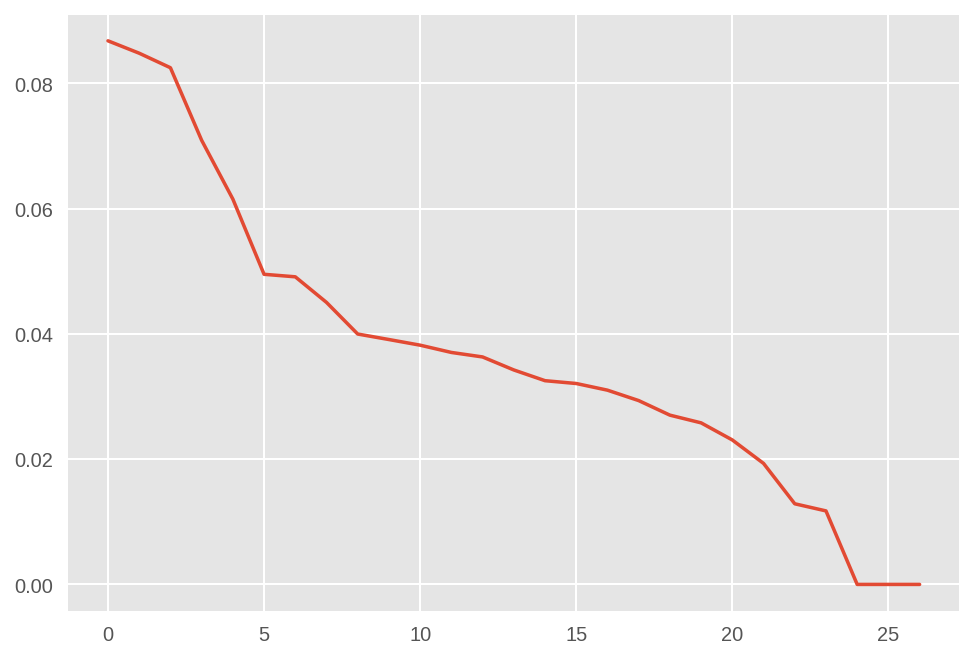

In [0]:
plt.plot(range(len(pca.explained_variance_ratio_)),pca.explained_variance_ratio_)

In [0]:
#so if we only needed a 99% variance, we need: 
pca=PCA(0.99) 
X_new=pca.fit_transform(X_train) 
print (X_new.shape )


(47643, 24)


In [0]:
pca = PCA(n_components=24)
X_train = pca.fit_transform(X_train)  
X_test = pca.transform(X_test)  

In [0]:
random_forest = RandomForestClassifier(n_estimators=200)
random_forest.fit(X_train,y_train)

Y_pred = random_forest.predict(X_test)
random_forest.score(X_test, y_test)
acc_random_forest1 = round(random_forest.score(X_test, y_test) * 100, 2)

sk_report = classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=Y_pred)

print("Accuracy" , acc_random_forest1)
print(sk_report)
pd.crosstab(y_test, Y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)

Accuracy 83.91
              precision    recall  f1-score   support

         1.0   0.000000  0.000000  0.000000       101
         2.0   0.523810  0.024083  0.046049      1827
         3.0   0.841295  0.996694  0.912425      9983

   micro avg   0.839056  0.839056  0.839056     11911
   macro avg   0.455035  0.340259  0.319492     11911
weighted avg   0.785463  0.839056  0.771797     11911



Predicted,2.0,3.0,All
Actual,,,
1.0,7,94,101
2.0,44,1783,1827
3.0,33,9950,9983
All,84,11827,11911


In [0]:
#random forest parameter tunning

param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'min_samples_leaf': [5, 10, 15],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300]
}
# Create a based model
random_f = RandomForestClassifier()
# Instantiate the grid search model
grid_search = RandomizedSearchCV(estimator = random_f, param_distributions = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)


grid_search.fit(X_train,y_train)

Y_pred = random_forest.predict(X_test)
random_forest.score(X_test, y_test)
acc_random_forest1 = round(random_forest.score(X_test, y_test) * 100, 2)

sk_report = classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=Y_pred)

print("Accuracy" , acc_random_forest1)
print(sk_report)
pd.crosstab(y_test, Y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 14.8min finished


Accuracy 83.91
              precision    recall  f1-score   support

         1.0   0.000000  0.000000  0.000000       101
         2.0   0.523810  0.024083  0.046049      1827
         3.0   0.841295  0.996694  0.912425      9983

   micro avg   0.839056  0.839056  0.839056     11911
   macro avg   0.455035  0.340259  0.319492     11911
weighted avg   0.785463  0.839056  0.771797     11911



Predicted,2.0,3.0,All
Actual,,,
1.0,7,94,101
2.0,44,1783,1827
3.0,33,9950,9983
All,84,11827,11911


## Data Visualization

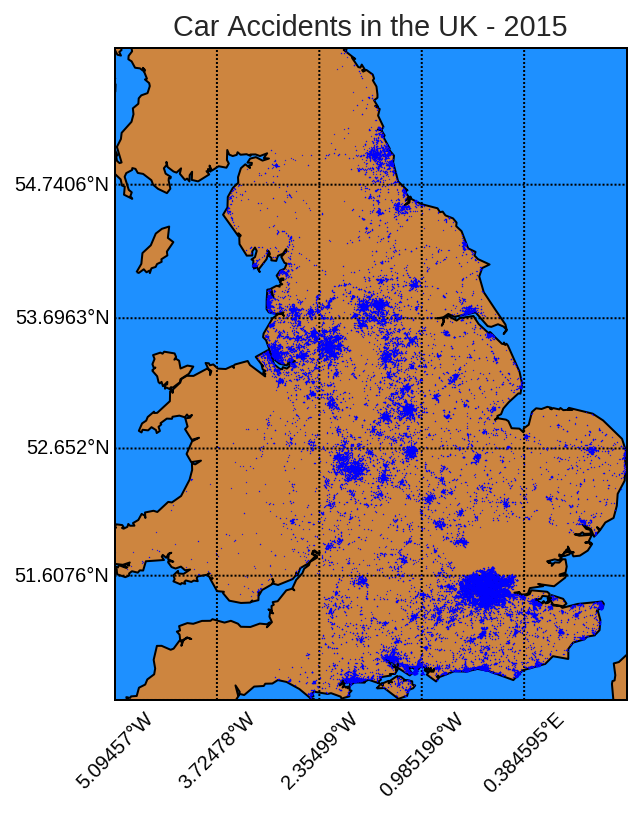

In [0]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import csv


lats= list(accidents['Latitude'])
lons = list(accidents['Longitude'])

#zoom from coordinates
zoom_scale = 0

# Setup the bounding box and bounds of the map
bbox = [np.min(lats)-zoom_scale,np.max(lats)+zoom_scale,\
        np.min(lons)-zoom_scale,np.max(lons)+zoom_scale]

plt.figure(figsize=(12,6))
# Define the projection, scale, the corners of the map, and the resolution.
m = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
            llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i')

# Draw coastlines and fill continents and water with color
m.drawcoastlines()
m.fillcontinents(color='peru',lake_color='dodgerblue')

# draw parallels, meridians, and color boundaries
m.drawparallels(np.arange(bbox[0],bbox[1],(bbox[1]-bbox[0])/5),labels=[1,0,0,0])
m.drawmeridians(np.arange(bbox[2],bbox[3],(bbox[3]-bbox[2])/5),labels=[0,0,0,1],rotation=45)
m.drawmapboundary(fill_color='dodgerblue')

# build and plot coordinates onto map
x,y = m(lons,lats)
m.plot(x,y,'b*',markersize=1)
plt.title("Car Accidents in the UK - 2015")
plt.savefig('car_accidentsUK_plot.png', format='png', dpi=500)
plt.show()

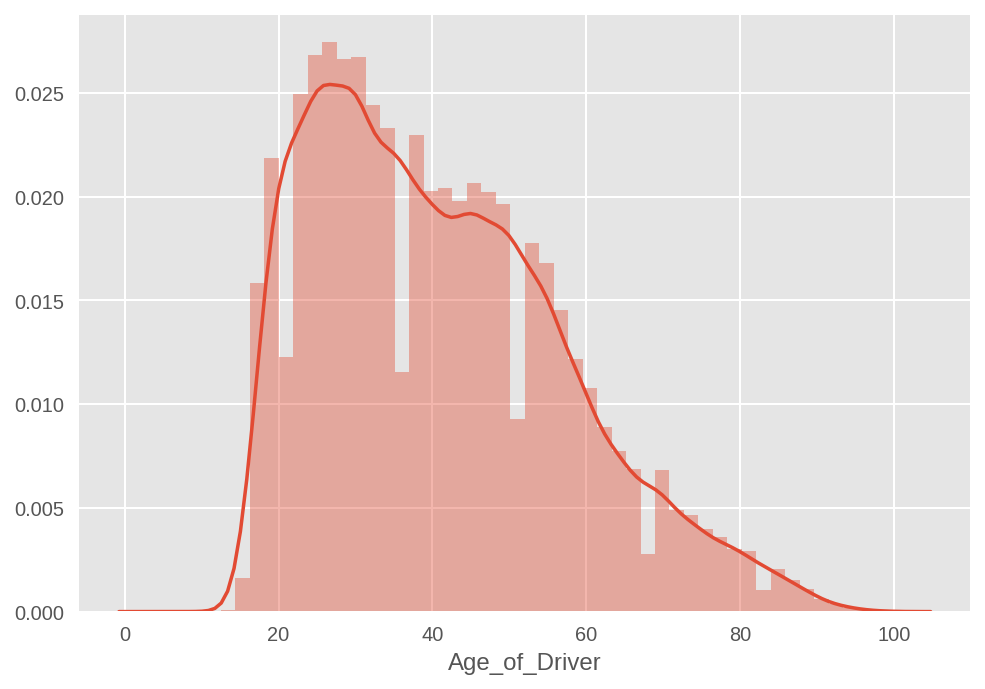

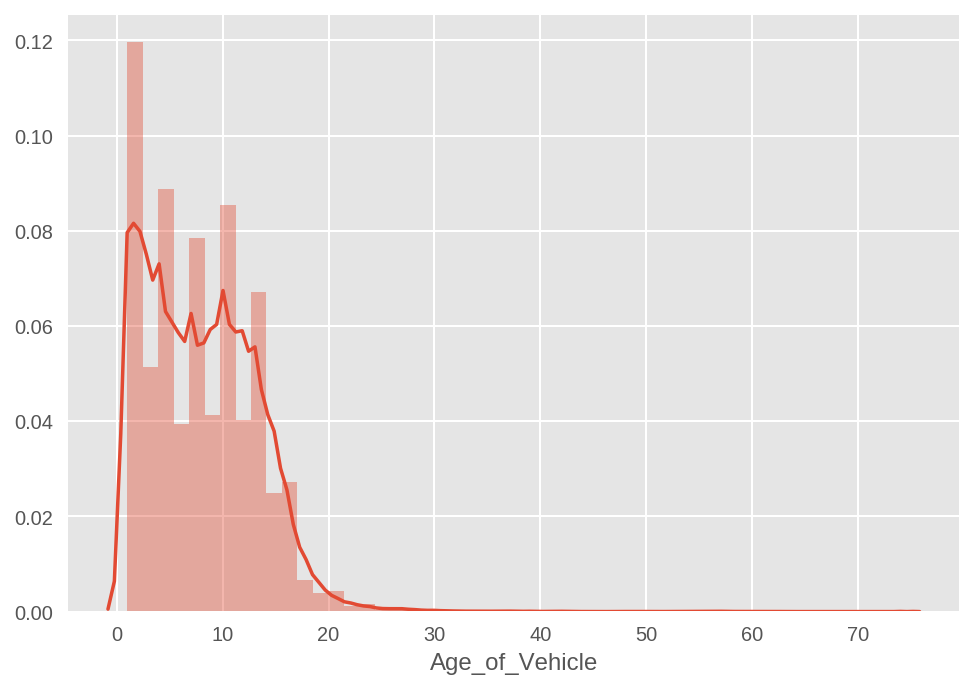

In [0]:

sns.distplot(accidents['Age_of_Driver']);
fig = plt.figure()
sns.distplot(accidents['Age_of_Vehicle']);
fig = plt.figure()

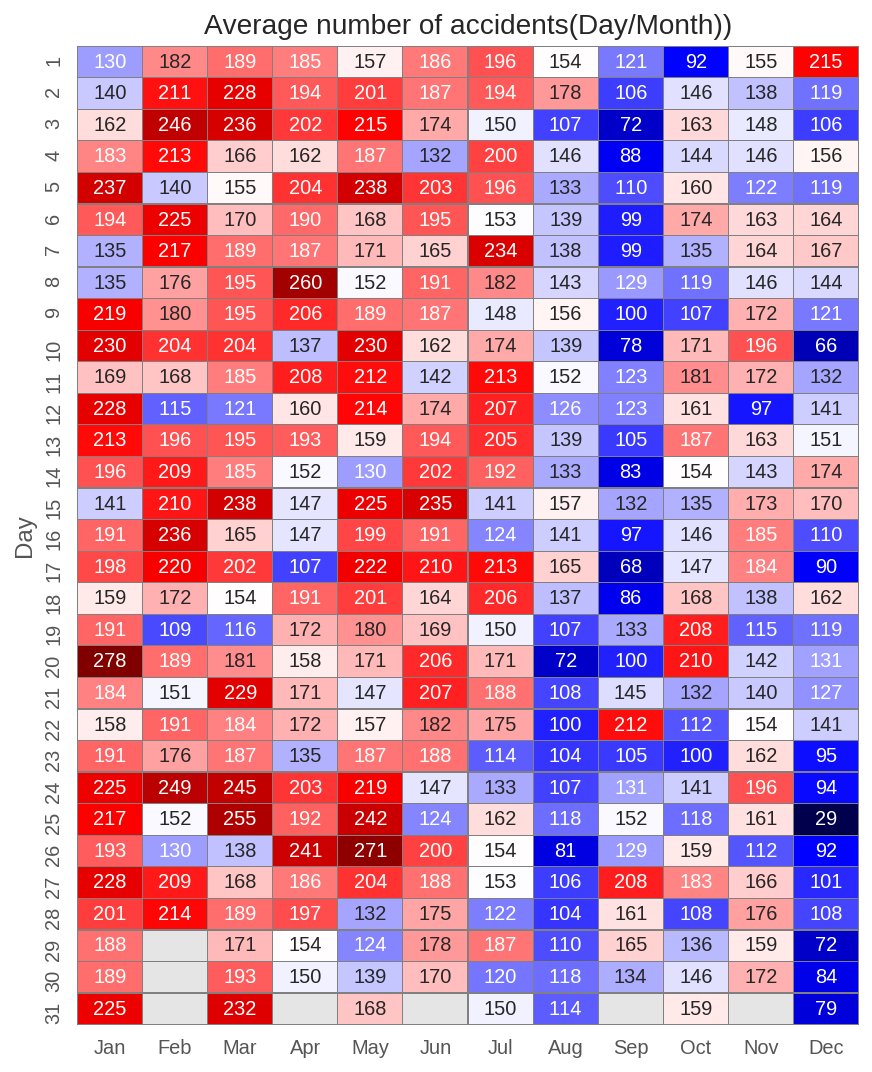

In [0]:
accidents_pivot_table = accidents.pivot_table(values='Date', index='Day', columns='Month', aggfunc=len)
accidents_pivot_table_date_count = accidents.pivot_table(values='Date', index='Day', columns='Month', aggfunc=lambda x: len(x.unique()))
accidents_average = accidents_pivot_table/accidents_pivot_table_date_count
accidents_average.columns = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.figure(figsize=(7,9))
plt.title('Average number of accidents(Day/Month))', fontsize=14)
sns.heatmap(accidents_average.round(), cmap='seismic', linecolor='grey',linewidths=0.1, cbar=False, annot=True, fmt=".0f")

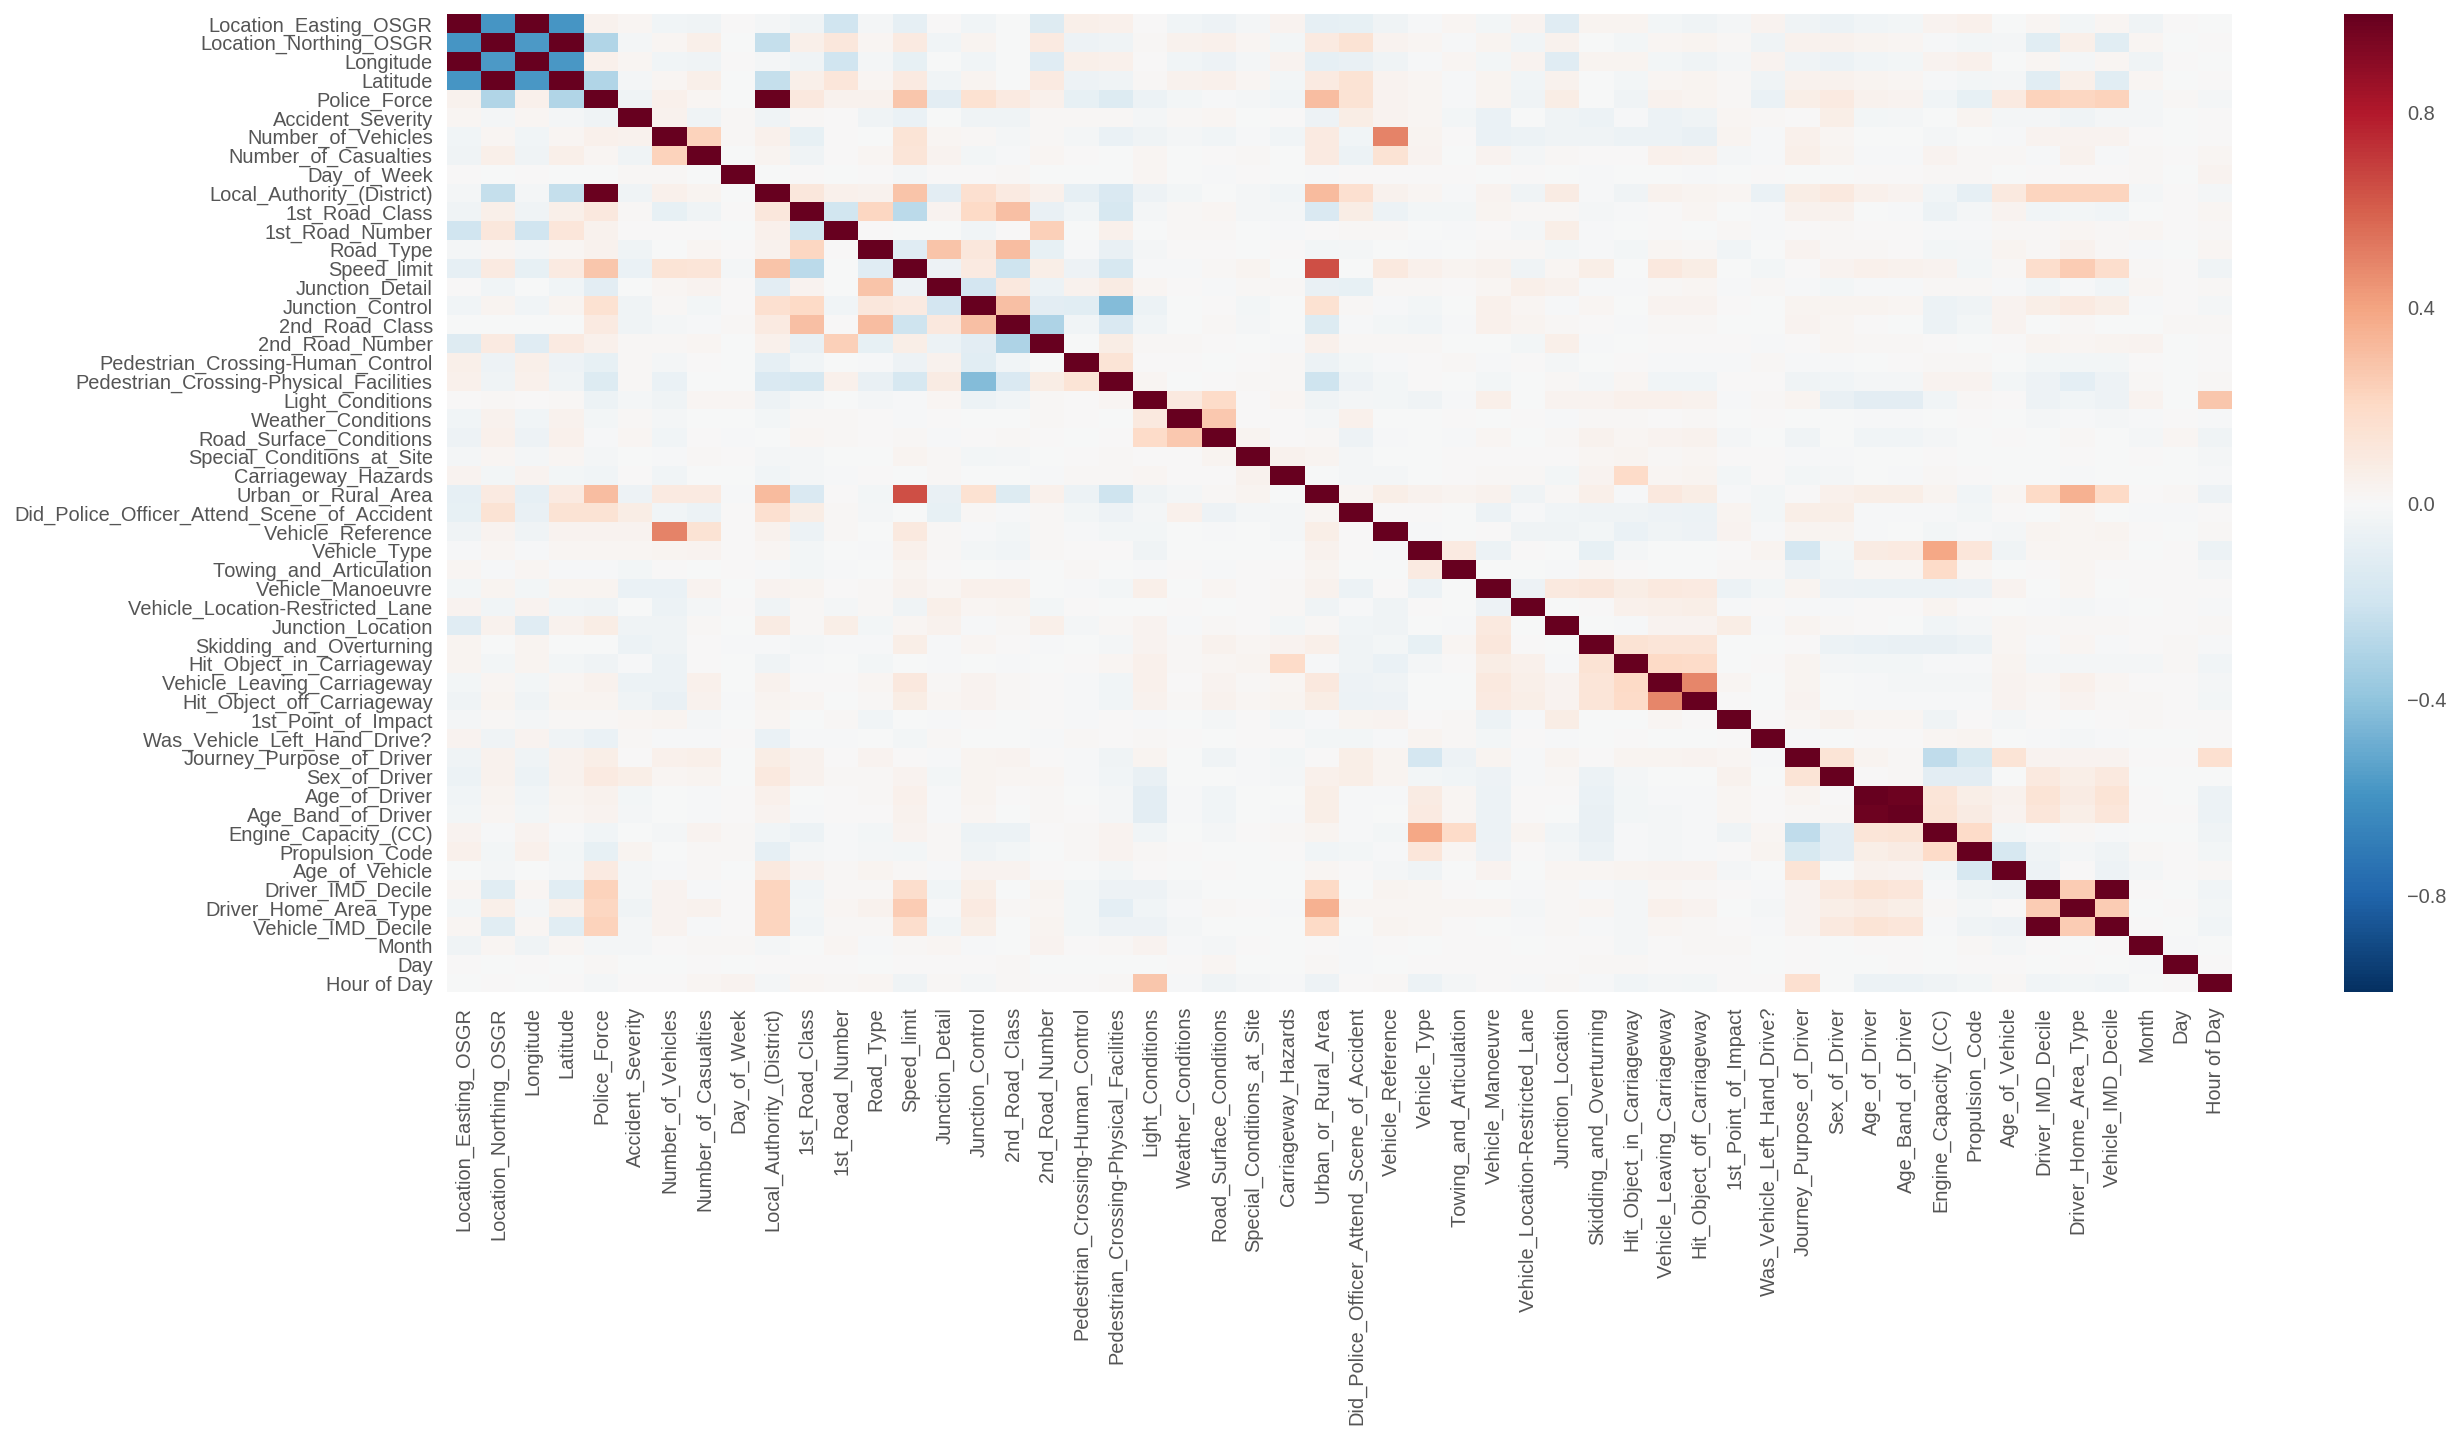

In [0]:
corr =  accidents.corr()
plt.subplots(figsize=(20,9))
sns.heatmap(corr)

In [0]:
accidents.Accident_Severity.describe()

count    59554.000000
mean         2.831699
std          0.393816
min          1.000000
25%          3.000000
50%          3.000000
75%          3.000000
max          3.000000
Name: Accident_Severity, dtype: float64